# Model Comparisson

In [1]:
from pathlib import Path

import mlflow
import pickle

import pandas as pd
import numpy as np
import torch
from numpy.typing import NDArray

import seaborn as sns
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = Path("../../data/processed")
EXPERIMENT_NAME = "fs_06_load_calendar_future_weather"
OUTPUT_PATH = DATA_PATH / "ml_data" / EXPERIMENT_NAME

WINDOW_SIZE = 4*24*7 # 672

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

## First: Start the MLFlow-Server for logging the experiments

Run the following command: 

Powershell:

mlflow server ` 
    --backend-store-uri sqlite:///mlflow.db ` 
    --default-artifact-root ./mlartifacts/  


Bash / Git Bash / WSL / Linux / macOS
mlflow server \
  --backend-store-uri sqlite:///mlflow.db \
  --default-artifact-root ./mlartifacts


In [3]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")

## Load the best models (LSTM, Bayesian LSTM, Propeht) and Perfomance Metrics

In [4]:
performance_df = pd.DataFrame(columns=["Model", "RSME_Overall", "MAE_Overall", "RSME_h1", "RSME_h4", "RSME_h12", "RSME_h24", "RSME_h48", "RSME_h96"])

In [5]:
LSTM_RUN_ID = "9de69e1bb0844ca29f3267bca6f7674e"
BAYESIAN_LSTM_RUN_ID = "2ccd3a12be4d4ec484be5af5fc8ab4e3"
PROPHET_RUN_ID = "73f7dd056c9c4b38907b476f7bf47615"

In [6]:
mlflow.set_experiment("load_forecasting_bayesian_lstm")

ranked_checkpoints = mlflow.search_logged_models(
    filter_string=f"source_run_id='{BAYESIAN_LSTM_RUN_ID}'",
    order_by=[{"field_name": "metrics.val_nll", "ascending": True}],
    output_format="list",
)

best_checkpoint = ranked_checkpoints[0]

baysian_lstm = mlflow.pytorch.load_model(best_checkpoint.model_uri) # pyright: ignore

run = mlflow.get_run(run_id=BAYESIAN_LSTM_RUN_ID)
metrics = run.data.metrics

rmse = run.data.metrics["test_rmse_unscaled"]
rmse_h1 = run.data.metrics["rmse_h1"]
rmse_h4 = run.data.metrics["rmse_h4"]
rmse_h12 = run.data.metrics["rmse_h12"]
rmse_h24 = run.data.metrics["rmse_h24"]
rmse_h48 = run.data.metrics["rmse_h48"]
rmse_h96 = run.data.metrics["rmse_h96"]
mae = run.data.metrics["test_mae_unscaled"]

performance_df.loc[len(performance_df)] = ["bayesian_lstm", rmse, mae, rmse_h1, rmse_h4, rmse_h12, rmse_h24, rmse_h48, rmse_h96]

In [7]:
mlflow.set_experiment("load_forecasting_vanilla_lstm")

ranked_checkpoints = mlflow.search_logged_models(
    filter_string=f"source_run_id='{LSTM_RUN_ID}'",
    order_by=[{"field_name": "metrics.val_mse", "ascending": True}],
    output_format="list",
)

best_checkpoint = ranked_checkpoints[0]

lstm = mlflow.pytorch.load_model(best_checkpoint.model_uri) # pyright: ignore

run = mlflow.get_run(run_id=LSTM_RUN_ID)
metrics = run.data.metrics

rmse = run.data.metrics["test_rmse_unscaled"]
rmse_h1 = run.data.metrics["rmse_h1"]
rmse_h4 = run.data.metrics["rmse_h4"]
rmse_h12 = run.data.metrics["rmse_h12"]
rmse_h24 = run.data.metrics["rmse_h24"]
rmse_h48 = run.data.metrics["rmse_h48"]
rmse_h96 = run.data.metrics["rmse_h96"]
mae = run.data.metrics["test_mae_unscaled"]

performance_df.loc[len(performance_df)] = ["lstm", rmse, mae, rmse_h1, rmse_h4, rmse_h12, rmse_h24, rmse_h48, rmse_h96]


In [8]:
mlflow.set_experiment("load_forecasting_prophet")

ranked_checkpoints = mlflow.search_logged_models(
    filter_string=f"source_run_id='{PROPHET_RUN_ID}'",
    order_by=[{"field_name": "metrics.val_mse", "ascending": True}],
    output_format="list",
)

best_checkpoint = ranked_checkpoints[0]

prophet_model = mlflow.prophet.load_model(best_checkpoint.model_uri) # pyright: ignore

mlflow.get_run(run_id=PROPHET_RUN_ID)

run = mlflow.get_run(run_id=PROPHET_RUN_ID)
metrics = run.data.metrics

rmse = run.data.metrics["rmse"]
rmse_h1 = run.data.metrics["rmse_h1"]
rmse_h4 = run.data.metrics["rmse_h4"]
rmse_h12 = run.data.metrics["rmse_h12"]
rmse_h24 = run.data.metrics["rmse_h24"]
rmse_h48 = run.data.metrics["rmse_h48"]
rmse_h96 = run.data.metrics["rmse_h96"]
mae = run.data.metrics["mae"]

performance_df.loc[len(performance_df)] = ["prophet", rmse, mae, rmse_h1, rmse_h4, rmse_h12, rmse_h24, rmse_h48, rmse_h96]


## Comparisson Plots

### RSME, MAE and Horizon-Error-Profile

In [9]:
overall_df = performance_df[["Model", "RSME_Overall", "MAE_Overall"]]

overall_long = overall_df.melt(
    id_vars="Model",
    var_name="Metric",
    value_name="Error"
)

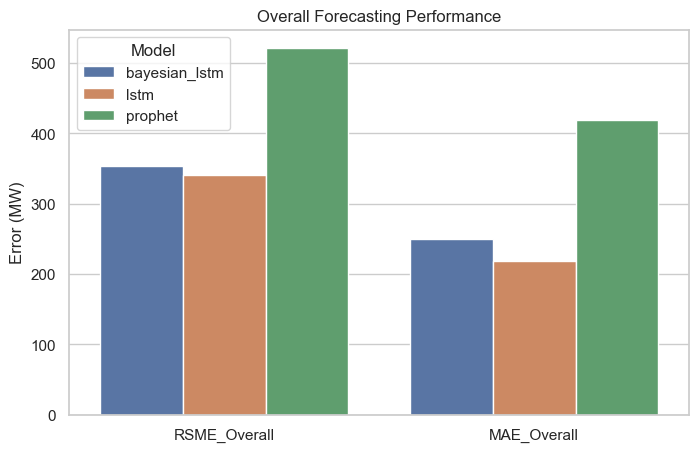

In [10]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.barplot(
    data=overall_long,
    x="Metric",
    y="Error",
    hue="Model",
    errorbar=None,
    ax=ax
)

ax.set_ylabel("Error (MW)")
ax.set_xlabel("")
ax.set_title("Overall Forecasting Performance");


In [11]:
horizon_cols = ["RSME_h1", "RSME_h4", "RSME_h12", "RSME_h24", "RSME_h48", "RSME_h96"]

horizon_df = performance_df[["Model"] + horizon_cols]

horizon_long = horizon_df.melt(
    id_vars="Model",
    var_name="Horizon",
    value_name="RMSE"
)

horizon_long["Horizon"] = (
    horizon_long["Horizon"]
    .str.replace("RSME_h", "")
    .astype(int)
)

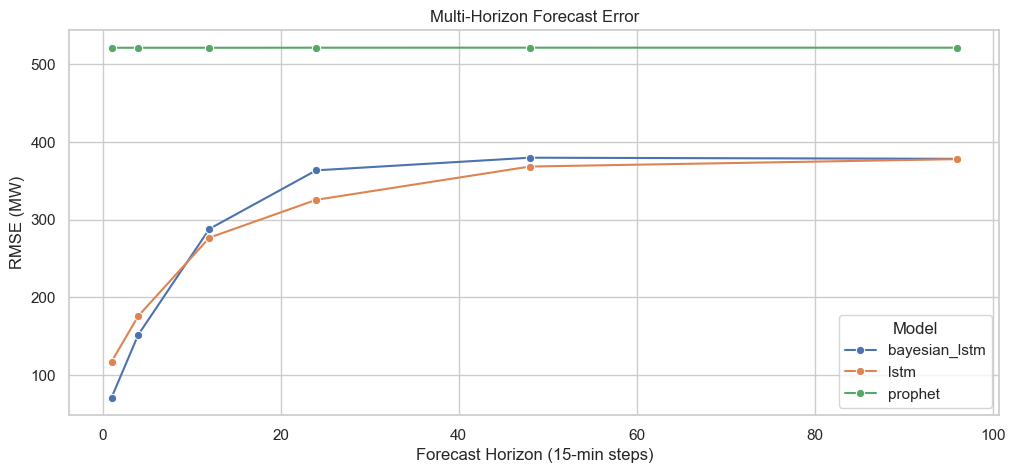

In [12]:
fig, ax = plt.subplots(figsize=(12, 5))

sns.lineplot(
    data=horizon_long,
    x="Horizon",
    y="RMSE",
    hue="Model",
    marker="o",
    ax=ax
)

ax.set_xlabel("Forecast Horizon (15-min steps)")
ax.set_ylabel("RMSE (MW)")
ax.set_title("Multi-Horizon Forecast Error")

ax.legend(title="Model");

## Sample predictions

In [13]:
raw_data = pd.read_parquet(DATA_PATH /  "data_combined.parquet")

raw_data

,actual_load_mw,t2m_future,ssrd_future,tp_future,wind_speed_future,is_weekday,is_holiday
period,,,,,,,
2018-10-01 00:00:00+00:00,5256.0,277.421722,0.0,0.000000e+00,1.758537,True,0
2018-10-01 00:15:00+00:00,5204.0,277.421722,0.0,0.000000e+00,1.758537,True,0
2018-10-01 00:30:00+00:00,5178.0,277.421722,0.0,0.000000e+00,1.758537,True,0
2018-10-01 00:45:00+00:00,5151.0,277.421722,0.0,0.000000e+00,1.758537,True,0
2018-10-01 01:00:00+00:00,5187.0,277.252350,0.0,6.201566e-08,1.709355,True,0
...,...,...,...,...,...,...,...
2025-10-08 23:00:00+00:00,5667.0,281.028931,0.0,8.888660e-09,1.151026,True,0
2025-10-08 23:15:00+00:00,5618.0,281.028931,0.0,8.888660e-09,1.151026,True,0
2025-10-08 23:30:00+00:00,5534.0,281.028931,0.0,8.888660e-09,1.151026,True,0


In [14]:
sample_ranges = {
    "normal_winter_week": (
        "2024-11-04 00:00:00+00:00",
        "2024-11-10 23:59:59+00:00",
    ),
    "normal_summer_week": (
        "2024-06-17 00:00:00+00:00",
        "2024-06-23 23:59:59+00:00",
    ),
    "winter_holiday_period": (
        "2023-12-01 00:00:00+00:00",
        "2024-02-01 23:59:59+00:00",
    ),
}

sample_y = {
    name: raw_data.loc[start:end, "actual_load_mw"]
    for name, (start, end) in sample_ranges.items() 
}

# sample_y["normal_winter_week"]
# sample_y["normal_summer_week"]
# sample_y["winter_holiday_period"]

In [15]:
# Load the scalers
scalers_dir = OUTPUT_PATH / "scalers"

with open(scalers_dir / "y_scaler.pkl", "rb") as f:
    y_scaler = pickle.load(f)

with open(scalers_dir / "X_scaler.pkl", "rb") as f:
    X_scaler = pickle.load(f)

In [16]:
def preprocess_to_prophet_df(df, target):
    prophet_df = df.rename(columns={target: "y"})
    prophet_df["ds"] = prophet_df.index
    prophet_df["ds"]=prophet_df["ds"].dt.tz_convert(None)
    return prophet_df

def create_input_windows(df: pd.DataFrame, time_range):
    X_seq = []
    for ts in time_range:

        idx = df.index.get_loc(ts)
        X_seq.append(df.iloc[idx - WINDOW_SIZE : idx])

    return np.array(X_seq)

def scale_lstm_input(xb: NDArray, feature_names) -> torch.Tensor:
    N, S, F = xb.shape  # (batches, seq, features)

    X_flat = xb.reshape(-1, F) 
    X_flat = pd.DataFrame(X_flat, columns=feature_names)
    X = X_scaler.transform(X_flat).reshape(N, S, F)
    
    return torch.tensor(X, dtype=torch.float32)

def unscale_lstm_outputs(y_hat: NDArray[np.floating]):
    N, H  = y_hat.shape
    y_unscaled = y_scaler.inverse_transform(y_hat.reshape(-1, 1)).reshape(N, H)

    return y_unscaled

In [ ]:
sample_y_hat_lstm = {}

for name, (start, end) in sample_ranges.items():

    time_range = pd.date_range(
            start=start,
            end=end,
            freq="15min",
            tz="UTC"
        )
    
    xb = create_input_windows(raw_data, time_range) # (batches, seq, features)
    xb_scaled = scale_lstm_input(xb, raw_data.columns).to(DEVICE)

    with torch.no_grad():
        y_hat_scaled = lstm(xb_scaled) #(batch, horizon)
    y_hat_unscaled = unscale_lstm_outputs(y_hat_scaled.cpu().numpy())

    sample_y_hat_lstm[name] = pd.Series(y_hat_unscaled[:, 0], index = time_range)

In [38]:
sample_y_hat_bayesian_lstm = {}

for name, (start, end) in sample_ranges.items():

    time_range = pd.date_range(
            start=start,
            end=end,
            freq="15min",
            tz="UTC"
        )
    
    xb = create_input_windows(raw_data, time_range) # (batches, seq, features)
    xb_scaled = scale_lstm_input(xb, raw_data.columns).to(DEVICE)

    with torch.no_grad():
        y_hat_scaled = baysian_lstm(xb_scaled) #(batch, horizon*2)
        mu_s, log_var_s = torch.chunk(y_hat_scaled, 2, dim=-1)

    y_hat_unscaled = unscale_lstm_outputs(mu_s.cpu().numpy())

    sample_y_hat_bayesian_lstm[name] = pd.Series(y_hat_unscaled[:, 0], index = time_range)


In [20]:
sample_y_hat_prophet = {}

for name, (start, end) in sample_ranges.items():
    future_df = raw_data.loc[start:end]

    y_hat_prophet = prophet_model.predict(preprocess_to_prophet_df(future_df, target="actual_load_mw"))["yhat"].values

    sample_y_hat_prophet[name] = y_hat_prophet


In [24]:
sample_y_hat_lstm["normal_summer_week"].shape

(672, 96)

In [26]:
sample_y["normal_summer_week"].shape

(672,)

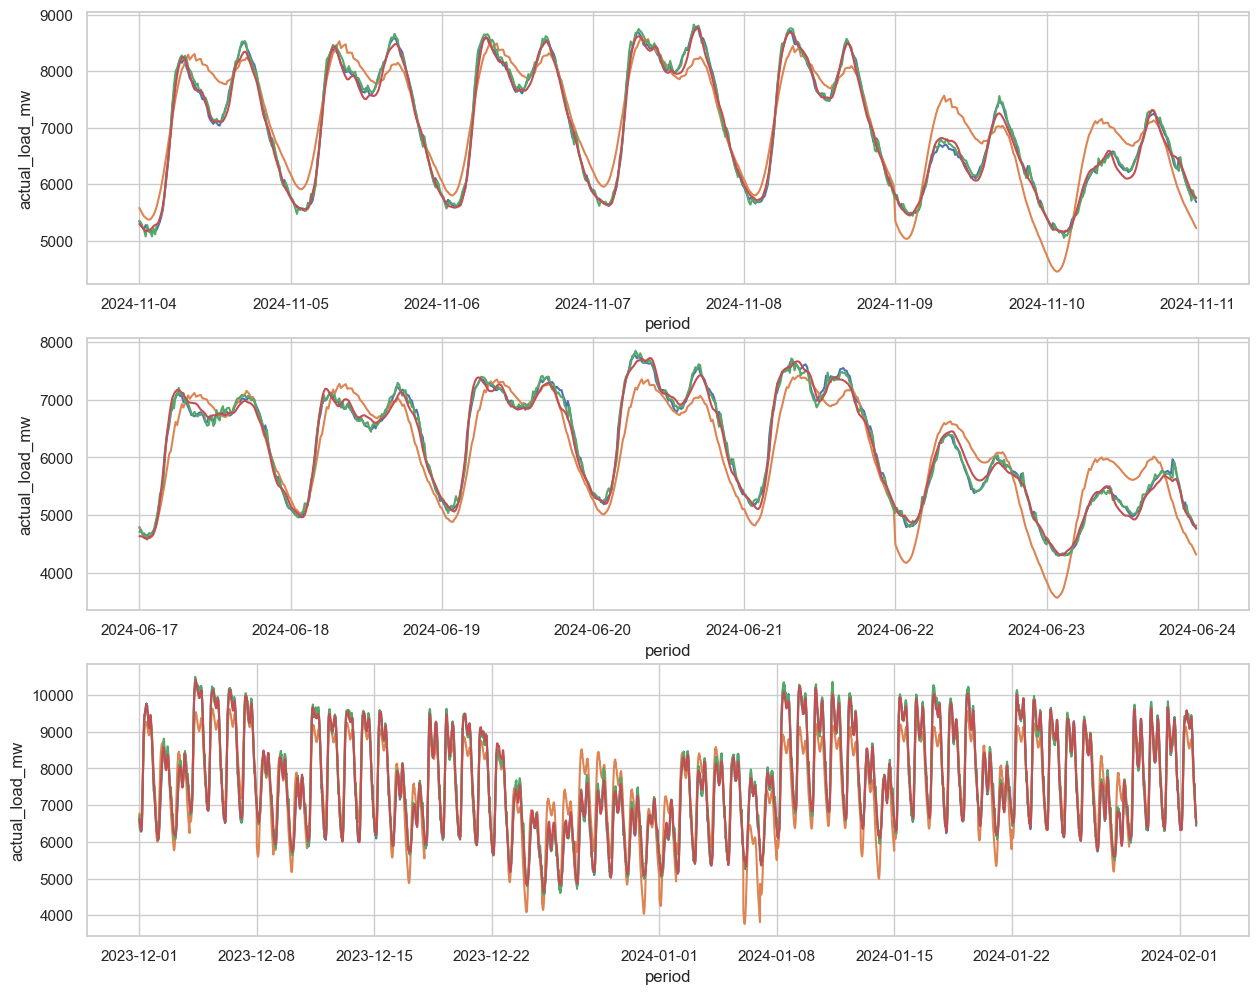

In [39]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15,12))
for i, name in enumerate(sample_ranges.keys()):
    y_true = sample_y[name]

    sns.lineplot(
        data=y_true,
        ax=axes[i],
        label="Actual",
        legend=False
    )

    axes[i].plot(
        y_true.index,
        sample_y_hat_prophet[name],
        label="Prophet"
    )
    
    axes[i].plot(
        y_true.index,
        sample_y_hat_bayesian_lstm[name],
        label="Bayesian LSMT"
    )
    
    axes[i].plot(
        y_true.index,
        sample_y_hat_lstm[name],
        label="LSTM"
    )